In [1]:
# Sklearn
from sklearn.model_selection import (train_test_split, RandomizedSearchCV,
                                     cross_val_score, learning_curve)
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             ConfusionMatrixDisplay,
                             classification_report,
                             roc_curve,
                             auc)
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Tf-keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Util
from scipy.stats import uniform, truncnorm, randint
import matplotlib.pyplot as plt 
import librosa.display
import seaborn as sns
import pandas as pd 
import numpy as np
import warnings
import time
import json
import os

warnings.filterwarnings("ignore")


2023-01-28 21:02:39.583921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### VISUALISING MFCC

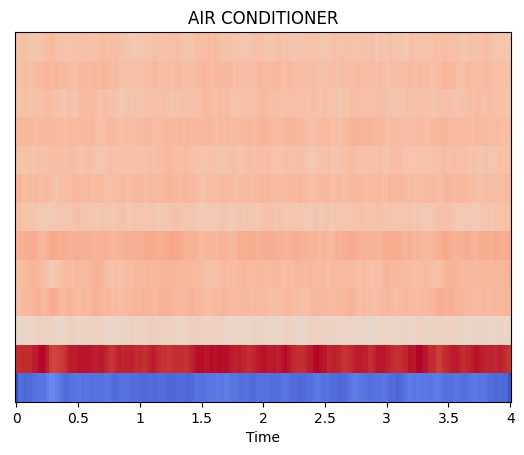

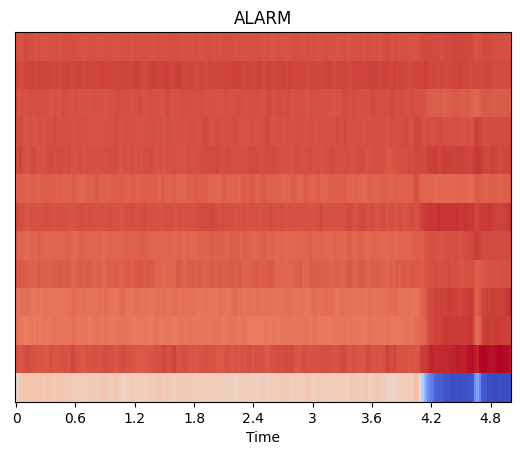

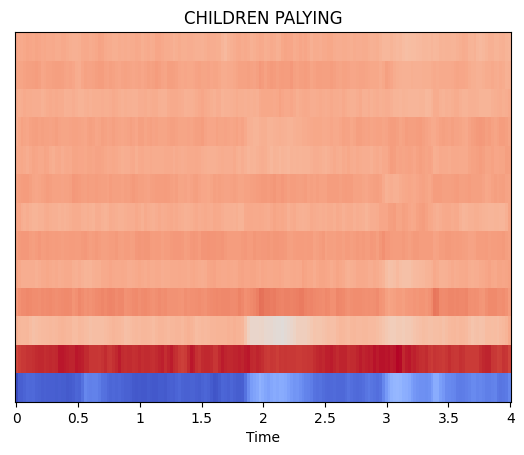

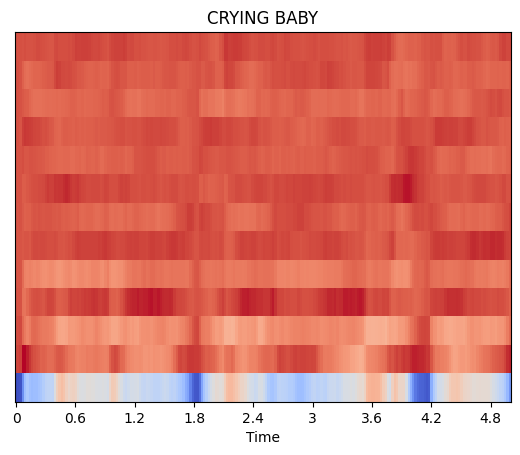

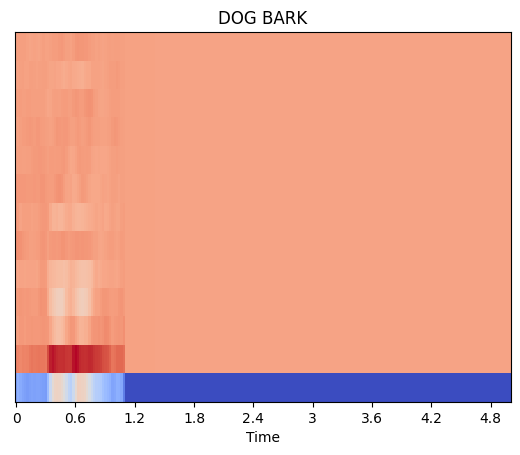

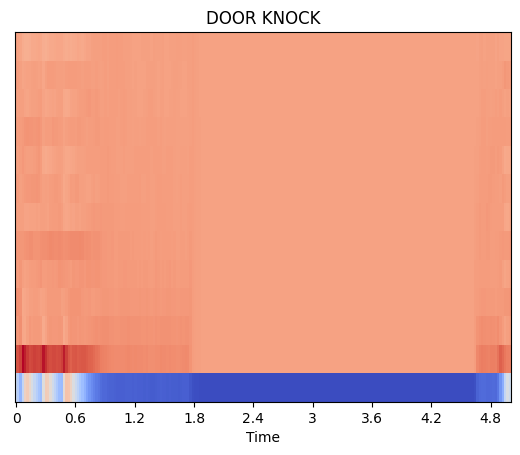

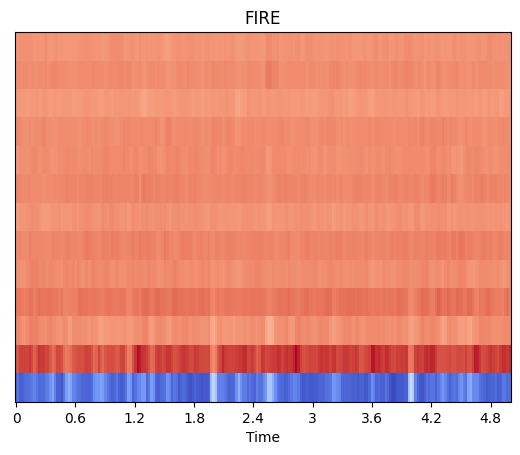

In [2]:
# MFCC
samples = [
    'combi_set/air conditioner/13230-0-0-7.wav', 'combi_set/alarm/1-14262-A-37.wav',
    'combi_set/children palying/6902-2-0-26.wav','combi_set/crying baby/1-60997-B-20.wav',
    'combi_set/dog bark/2-118072-A-0.wav', 'combi_set/door knock/2-118624-A-30.wav', 
    'combi_set/fire/1-17808-A-12.wav'
      ]

for file in samples:
    signal, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(signal, n_mfcc = 13,
                                sr = sr, hop_length = 512,
                                 n_fft = 2048)
    
    librosa.display.specshow(mfcc, x_axis = 'time', sr = sr)
    plt.title(file.split('/')[1].upper())
    
    plt.show()
    
    


### BUILDING A CLASSIFIER WITH MFCC FEATURES

In [3]:
# COMPILING EXTRACTED MFCC FEATURES INTO A SINGLE DATAFRAME 

mfcc_data = []
mfcc_json = [
             'crying baby_mfcc_features.json',
             'children palying_mfcc_features.json',
             'air conditioner_mfcc_features.json',
             'dog bark_mfcc_features.json',
             'fire_mfcc_features.json',
             'door knock_mfcc_features.json',
             'alarm_mfcc_features.json',
             
             ]

for feature in mfcc_json: 
    with open(os.path.join('mfcc_feature', feature), 'r') as f:
        mfcc_hold = pd.DataFrame(json.load(f)).sample(70)
        mfccs = mfcc_hold['feature'].apply(pd.Series)
        concat = pd.concat([mfcc_hold, mfccs], axis = 1).drop('feature', axis = 1)
        mfcc_data.append(concat)
    

mfcc_df = pd.concat(mfcc_data, ignore_index=True)

In [4]:
# 10 RANDOM SAMPLES FROM DATASET
mfcc_df.sample(10)

,label,file_path,0,1,2,3,4,5,6,7,8,9,10,11,12
196,air conditioner,combi_set/air conditioner/177729-0-0-20.wav,-300.259705,81.974464,-27.826162,17.052439,-11.980359,25.489408,-10.851119,10.574474,-3.919808,5.734190,-11.606422,-0.041853,-6.891456
437,alarm,combi_set/alarm/5-219242-A-37.wav,-463.581024,7.513696,2.002412,35.375278,3.666669,30.867977,-0.927458,10.422472,16.625593,21.041719,-17.007225,13.728892,17.371294
38,crying baby,combi_set/crying baby/HumanBaby+CTV05_39_02.wav,-357.558960,47.484943,0.525717,-0.825745,-13.073594,10.037084,-7.523165,5.017160,-6.306387,9.805662,-6.192846,-1.715728,-2.610607
438,alarm,combi_set/alarm/BoatAlarm+6025_66_1.wav,-294.249207,100.787903,-26.819979,53.060551,-32.235977,8.089683,-7.916108,19.834293,-9.798690,-21.000145,7.889843,-5.711067,-5.940341
25,crying baby,combi_set/crying baby/HumanBaby+6095_66_2.wav,-291.666351,9.445386,-54.682499,-14.550428,-7.863088,-16.068649,18.522406,23.726057,-14.746987,-9.925507,-0.285803,-8.048113,-12.439637
168,air conditioner,combi_set/air conditioner/204240-0-0-27.wav,-399.467194,197.399002,-17.185574,11.849483,7.910654,3.496775,11.886088,1.801666,5.371667,6.615011,3.085408,3.120273,-0.362824
424,alarm,combi_set/alarm/AlarmDistress+6010_06.wav,-256.933594,-125.481316,-74.658287,29.508957,-15.945287,-23.069326,22.996061,-3.729511,-2.432383,11.110518,31.529448,47.170746,12.562203
363,door knock,combi_set/door knock/GLASS-KNOCK_GEN-HDF-12936...,-479.419769,50.738419,24.728804,26.508427,6.289617,13.739432,6.850684,6.837233,4.876286,4.333309,1.985675,3.668743,0.613921
474,alarm,combi_set/alarm/AlarmSmokeDetector+6010_07.wav,-584.271240,-25.568913,-14.075581,47.333252,-5.203693,-26.593685,36.097843,8.690375,-38.784321,34.971878,6.688341,-35.694572,28.573048
9,crying baby,combi_set/crying baby/HUMAN-BABY_GEN-HDF-14825...,-322.800995,0.256740,-36.074509,1.079252,-20.231712,9.070004,-9.631671,15.410595,-14.462437,15.251625,-4.749282,-5.437946,3.261786


In [5]:
# SHAPE 
mfcc_df.shape

(490, 15)

In [6]:
# CLASSES 
mfcc_df.label.unique()

array(['crying baby', 'children palying', 'air conditioner', 'dog bark',
       'fire', 'door knock', 'alarm'], dtype=object)

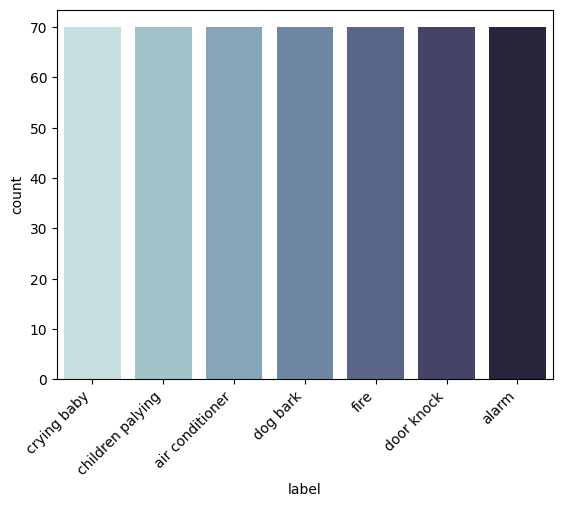

In [7]:
# VISUALISING INSTANCES PER CLASS
plot = sns.countplot(data = mfcc_df, x = mfcc_df['label'], palette = 'ch:start=.2,rot=-.3')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
None



##### MODEL TRAINING  

In [8]:
# INDEPENDENT AND TARGET SPLIT
X = np.array(mfcc_df.drop(['label', 'file_path'], axis = 1))
y = np.array(mfcc_df['label'])

In [9]:
# TRAIN/TEST SPLIT (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print('Number of training samples: ', X_train.shape[0])
print('Number of testing samples: ', X_test.shape[0])

Number of training samples:  392
Number of testing samples:  98


In [10]:
# ENCODING LABELS
le  = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


In [11]:
np.save('classes.npy', le.classes_)

##### SUPPORT VECTOR MACHINE(SVM) CLASSIFIER 

In [12]:
svc = SVC(probability=True)

In [13]:
# TUNING HYPERPARAMETERS SVM
sv_tuning_params = {
                    'C': uniform(0.1, 100), 
                    'gamma': ['scale', 'auto'],
                    'kernel': ['rbf', 'poly', 'sigmoid']
                    }

tuning_svm = RandomizedSearchCV(svc, sv_tuning_params,
                                  n_iter = 10, cv = 5, 
                                  scoring = 'accuracy',
                                  refit = 'accuracy',
                                  n_jobs = -1
                                  )

In [14]:
tuning_svm.fit(X_train, y_train_encoded)

RandomizedSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15aebdbe0>,
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   refit='accuracy', scoring='accuracy')

In [15]:
model_svc =  tuning_svm.best_estimator_

In [16]:
model_svc.fit(X_train, y_train_encoded)

SVC(C=55.09152899055935, probability=True)

#### SVM EVALUTATION 

In [17]:
print(f'Accuracy score for training data SVM: {model_svc.score(X_train, y_train_encoded):.2f}')
print(f'Accuracy for testing data SVM: {accuracy_score(y_test_encoded, model_svc.predict(X_test)):.2f}')

Accuracy score for training data SVM: 0.85
Accuracy for testing data SVM: 0.74


In [18]:
print(classification_report(y_test_encoded, model_svc.predict(X_test), digits = 2))


              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.80      0.47      0.59        17
           2       0.54      0.70      0.61        10
           3       0.69      0.85      0.76        13
           4       0.75      0.92      0.83        13
           5       0.92      1.00      0.96        12
           6       0.78      0.70      0.74        20

    accuracy                           0.74        98
   macro avg       0.75      0.76      0.74        98
weighted avg       0.76      0.74      0.74        98



In [19]:
# CLASSIFICATION REPORT 
svm_report = classification_report(y_test_encoded, model_svc.predict(X_test), output_dict = True)


In [20]:
svm_report['macro avg']

{'precision': 0.7466880341880342,
 'recall': 0.761732385261797,
 'f1-score': 0.7434767495116267,
 'support': 98}

#### ARTIFICIAL NEURAL NETWORKS(ANN) CLASSIFIER 

In [21]:
# ONE-HOT ENCODING TARGET LABELS FOR ANN
y_train_encoded_nn = to_categorical(y_train_encoded)
y_test_encoded_nn = to_categorical(y_test_encoded)

In [23]:
num_labels = y_train_encoded_nn.shape[1]
ann_model = Sequential()
ann_model.add(Dense(600, activation="relu", input_shape= (13,)))
ann_model.add(Dense(400, activation="relu"))
ann_model.add(Dense(num_labels, activation="softmax"))
ann_model.summary()

2023-01-28 21:05:12.206497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 600)               8400      
                                                                 
 dense_1 (Dense)             (None, 400)               240400    
                                                                 
 dense_2 (Dense)             (None, 7)                 2807      
                                                                 
Total params: 251,607
Trainable params: 251,607
Non-trainable params: 0
_________________________________________________________________


In [24]:
ann_model.compile(
    optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']
)

In [25]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=50, 
                               min_delta=0.001, 
                               mode='max')
mc = ModelCheckpoint('ann_model.h5', monitor='val_accuracy', mode='max', 
                      verbose=1, save_best_only=True)                           

In [26]:
num_epochs = 1000
num_batch_size = 128

t0 = time.time()

ann_results = ann_model.fit(
    X_train,
    y_train_encoded_nn,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test_encoded_nn),
    callbacks=[early_stopping, mc]
)

train_hist_m1 = pd.DataFrame(ann_results.history)
train_m1 = round(time.time() - t0, 3)

Epoch 1/1000
1/4 [======>.......................] - ETA: 5s - loss: 18.1109 - accuracy: 0.1719
Epoch 1: val_accuracy improved from -inf to 0.17347, saving model to ann_model.h5
4/4 [==============================] - 2s 173ms/step - loss: 22.0340 - accuracy: 0.1913 - val_loss: 35.0890 - val_accuracy: 0.1735
Epoch 2/1000
1/4 [======>.......................] - ETA: 0s - loss: 45.3585 - accuracy: 0.1406
Epoch 2: val_accuracy improved from 0.17347 to 0.37755, saving model to ann_model.h5
4/4 [==============================] - 0s 49ms/step - loss: 34.8090 - accuracy: 0.2270 - val_loss: 18.5832 - val_accuracy: 0.3776
Epoch 3/1000
3/4 [=====================>........] - ETA: 0s - loss: 21.0131 - accuracy: 0.3307
Epoch 3: val_accuracy improved from 0.37755 to 0.39796, saving model to ann_model.h5
4/4 [==============================] - 0s 60ms/step - loss: 20.9515 - accuracy: 0.3316 - val_loss: 9.7623 - val_accuracy: 0.3980
Epoch 4/1000
1/4 [======>.......................] - ETA: 0s - loss: 11.59

#### ANN EVALUATION 

In [27]:
saved_model = load_model('ann_model.h5')

In [28]:
_, train_acc = saved_model.evaluate(X_train, y_train_encoded_nn, verbose=0)

_, test_acc = saved_model.evaluate(X_test, y_test_encoded_nn, verbose=0)

print('Train: %.2f, Test: %.2f' % (train_acc, test_acc))

Train: 0.91, Test: 0.86


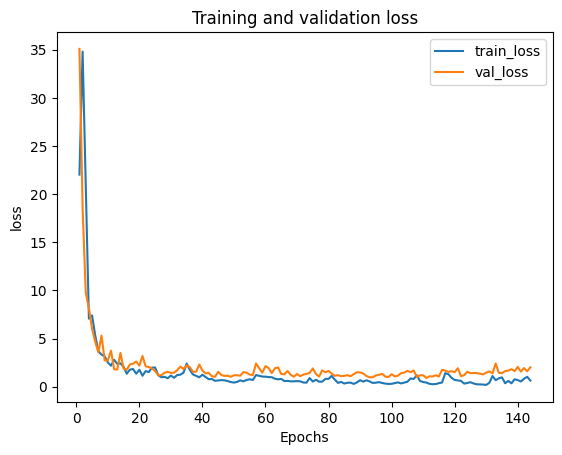

In [29]:
# LOSS CURVE 
train_metrics = ann_results.history['loss']
val_metrics = ann_results.history['val_'+'loss']
epochs = range(1, len(train_metrics) + 1)

plt.plot(epochs, train_metrics)
plt.plot(epochs, val_metrics)
plt.title('Training and validation '+ 'loss')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(["train_"+'loss', 'val_'+'loss'])
plt.show()


In [30]:
y_hat_ann = np.argmax(saved_model.predict(X_test),axis=1)
labels_ann = np.argmax(y_test_encoded_nn, axis=1)

4/4 [==============================] - 0s 3ms/step


In [31]:
# CLASSIFICATION REPORT 
print(classification_report(labels_ann, y_hat_ann, digits = 2))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       0.85      0.65      0.73        17
           2       1.00      0.80      0.89        10
           3       0.73      0.85      0.79        13
           4       0.79      0.85      0.81        13
           5       0.86      1.00      0.92        12
           6       1.00      0.90      0.95        20

    accuracy                           0.86        98
   macro avg       0.86      0.86      0.86        98
weighted avg       0.87      0.86      0.86        98



In [32]:
ann_report = classification_report(labels_ann, y_hat_ann, output_dict = True)
ann_report['macro avg']

{'precision': 0.8621206174777604,
 'recall': 0.8627666451195865,
 'f1-score': 0.8556783415741156,
 'support': 98}

#### COMPARING SVM AND ANN MODELS

In [33]:
svm_report['macro avg']['model'] = 'SVM'
ann_report['macro avg']['model'] = 'ANN'

In [34]:
models_reports = pd.DataFrame([svm_report['macro avg'], ann_report['macro avg']])

In [35]:
models_reports

,precision,recall,f1-score,support,model
0,0.746688,0.761732,0.743477,98,SVM
1,0.862121,0.862767,0.855678,98,ANN


Overall the ANN classifier performed better than SVM.

##### PREDICT HOLD OUT SET WITH ANN

In [36]:
def hold_out_df():
    """
    Returns a DataFrame of the holdout set
    """
    
    data = {}
    data['labels'] = []
    data['files'] = []


    for path, _, file in os.walk(os.path.join(os.getcwd(), 'hold_out_set')):
        if path != os.path.join(os.getcwd(), 'hold_out_set'):
            label = path.split('/')[-1]
            
            for _, _, file in os.walk(path):
                for i in file:
                    data['labels'].append(label)
                    data['files'].append(os.path.join(os.getcwd(), 'hold_out_set', label, i))

    return pd.DataFrame(zip(data['labels'], data['files']), columns = ['labels', 'files'])                
        

In [37]:
def predict(file):
    """
    Predicts the label of a audio file using ANN
    """
   
    predicted_labels = []
    le = LabelEncoder()
    le.classes_ = np.load('classes.npy', allow_pickle=True)
    saved_model = load_model('ann_model.h5')
    sample_rate = 22050
    duration = 5
    num_expected_samples = sample_rate * duration
    signal, sample_rate = librosa.load(file, res_type="kaiser_fast", duration= duration)
    
    
    if len(signal) < num_expected_samples:
        padded_signal = librosa.util.fix_length(signal, 
                                               size = num_expected_samples)

  
        mfcc = np.mean(librosa.feature.mfcc(y = padded_signal, sr = sample_rate, n_mfcc = 13).T, 
                       axis=0)

        
    else:
        mfcc = np.mean(librosa.feature.mfcc(y = signal, sr = sample_rate, n_mfcc = 13).T, axis=0)
    
    prediction_feature = np.array([mfcc])
    predicted_vector = np.argmax(saved_model.predict(prediction_feature), axis=-1)
    predicted_label = le.inverse_transform(predicted_vector)
    return predicted_label[0]
   

In [42]:
hold_out_preds = hold_out_df()

In [43]:
hold_out_preds['pred_labels'] = hold_out_preds['files'].apply(predict)

1/1 [==============================] - 0s 100ms/step


In [47]:
hold_out_preds.to_csv('hold_out_preds.csv', index = False)